<a href="https://colab.research.google.com/github/debashish-saha1/ESE_588_project/blob/main/ESE_588.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd


def download_file(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

download_file("https://raw.githubusercontent.com/debashish-saha1/ESE_588_project/main/Training_Data_588_Project_Spring2025.xlsx", "Training_Data_588_Project_Spring2025.xlsx")
download_file("https://raw.githubusercontent.com/debashish-saha1/ESE_588_project/main/Test_Data_588_Project_Spring2025.xlsx", "Test_Data_588_Project_Spring2025.xlsx")
download_file("https://raw.githubusercontent.com/debashish-saha1/ESE_588_project/main/Myresults.xlsx", "Myresults.xlsx")


In [2]:
# Install xgboost and lightgbm if not available
!pip install --quiet xgboost lightgbm

In [3]:
# Load the training and test data
training_data_path = "Training_Data_588_Project_Spring2025.xlsx"
test_data_path = "Test_Data_588_Project_Spring2025.xlsx"

# Load all sheets from both files
training_data = pd.read_excel(training_data_path)
test_data = pd.read_excel(test_data_path, sheet_name=None)

# Display summary info
training_data_info = {
    "shape": training_data.shape,
    "columns": training_data.columns.tolist(),
    "label_distribution": training_data.iloc[:, -1].value_counts().to_dict()
}

test_data_summary = {
    sheet_name: df.shape for sheet_name, df in test_data.items()
}

training_data.head(), training_data_info, test_data_summary

(   baseline_fhr  num_accelerations  num_decelerations    mean_fhr  median_fhr  \
 0         126.8                  1                  0  128.332500     127.000   
 1         150.2                  0                  3  138.904167     150.075   
 2         122.0                  0                  0  122.499375     122.000   
 3         148.0                  0                  0  148.792083     148.000   
 4         126.7                  0                  0  126.838333     127.000   
 
      std_fhr  min_fhr  max_fhr  range_fhr     rmssd  ...     hf_power  \
 0   7.491215    116.0    161.0       45.0  0.615101  ...    33.994750   
 1  29.163626     53.0    174.0      121.0  3.337170  ...  1902.811974   
 2   2.696738    114.0    130.0       16.0  0.488082  ...    26.049172   
 3   4.544945    139.0    163.0       24.0  0.554041  ...    18.670587   
 4   2.131634    121.0    138.0       17.0  0.519322  ...    30.189750   
 
    lf_hf_ratio  approx_entropy  sample_entropy       dfa  v

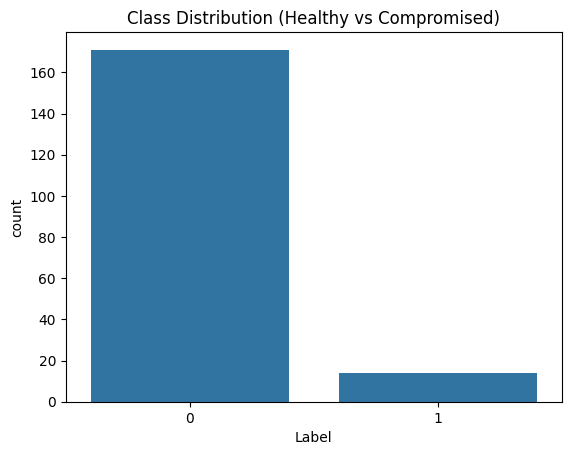

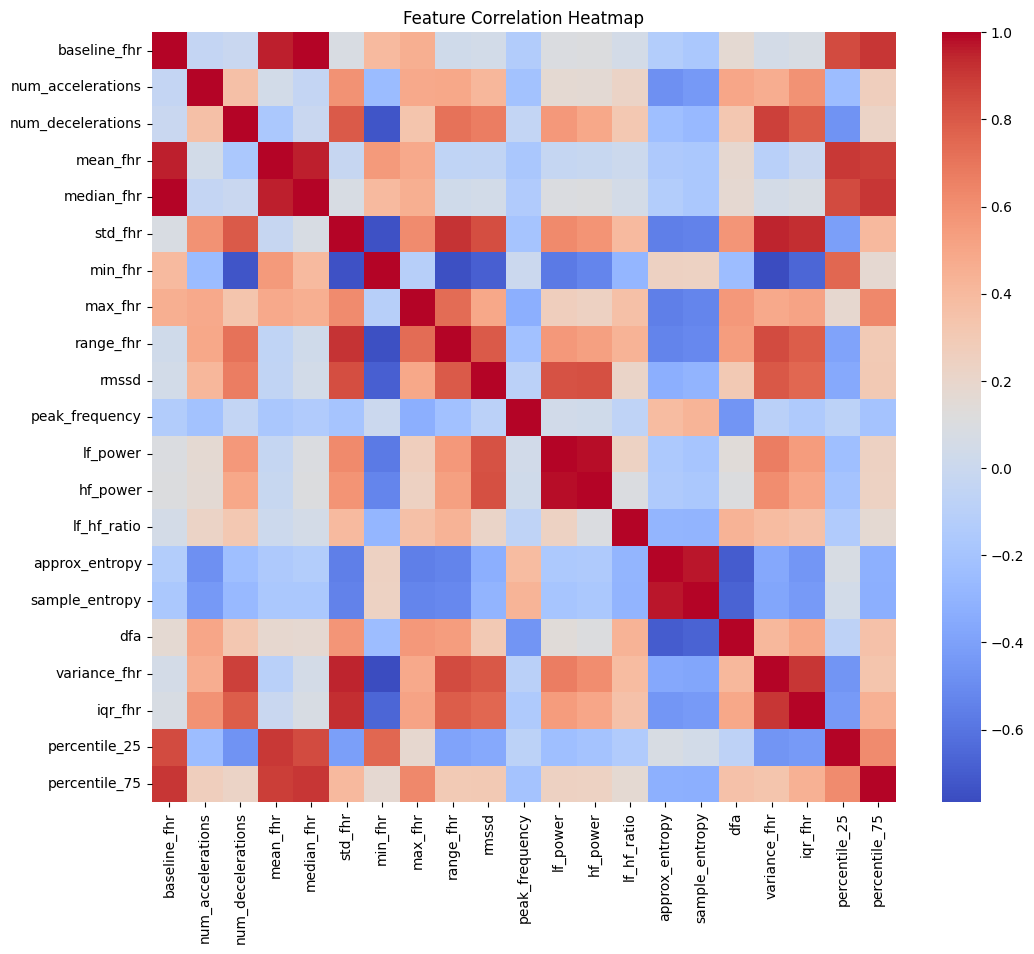

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Split features and labels
X = training_data.drop(columns=["Label"])
y = training_data["Label"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualize label imbalance
sns.countplot(x=y)
plt.title("Class Distribution (Healthy vs Compromised)")
plt.show()

# Plot a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(X).corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [5]:
# Re-import libraries after kernel reset
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb

# Load data
training_data = pd.read_excel("Training_Data_588_Project_Spring2025.xlsx")
X = training_data.drop(columns=["Label"])
y = training_data["Label"]

# Setup
scaler = StandardScaler()
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Define models
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "SVM": SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),
        random_state=42
    ),
    "PolyLogisticRegression": make_pipeline(
        PolynomialFeatures(degree=2),
        LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    )
}

# Initialize summary
metrics_summary = {
    model: {"Accuracy": [], "AUC": [], "TP": [], "FN": []}
    for model in models
}

# Train and evaluate
for train_index, val_index in sss.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    for name, model in models.items():
        if name in ["SVM", "PolyLogisticRegression"]:
            model.fit(X_train_scaled, y_train)
            preds = model.predict(X_val_scaled)
            probs = model.predict_proba(X_val_scaled)[:, 1]
        else:
            model.fit(X_train, y_train)
            preds = model.predict(X_val)
            probs = model.predict_proba(X_val)[:, 1]

        acc = accuracy_score(y_val, preds)
        auc = roc_auc_score(y_val, probs)
        cm = confusion_matrix(y_val, preds)
        tp = cm[1, 1]
        fn = cm[1, 0]

        metrics_summary[name]["Accuracy"].append(acc)
        metrics_summary[name]["AUC"].append(auc)
        metrics_summary[name]["TP"].append(tp)
        metrics_summary[name]["FN"].append(fn)

# Average results
avg_results = {
    name: {
        "Avg Accuracy": np.mean(scores["Accuracy"]),
        "Avg AUC": np.mean(scores["AUC"]),
        "Avg TP": np.mean(scores["TP"]),
        "Avg FN": np.mean(scores["FN"])
    }
    for name, scores in metrics_summary.items()
}

# Display results
avg_results_df = pd.DataFrame(avg_results).T.sort_values(by="Avg AUC", ascending=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for 

In [6]:
avg_results_df

,Avg Accuracy,Avg AUC,Avg TP,Avg FN
RandomForest,0.989189,1.000000,2.6,0.4
SVM,0.983784,1.000000,2.6,0.4
PolyLogisticRegression,0.989189,0.998039,2.6,0.4
XGBoost,0.989189,0.994118,2.8,0.2
LogisticRegression,0.978378,0.968627,2.4,0.6
GradientBoosting,0.989189,0.963725,2.8,0.2
KNN,0.962162,0.931373,1.6,1.4
MLP,0.956757,0.731373,1.4,1.6


In [7]:
# Re-import necessary tools
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Load training data
training_data = pd.read_excel("Training_Data_588_Project_Spring2025.xlsx")
X = training_data.drop(columns=["Label"])
y = training_data["Label"]

# Setup
scaler = StandardScaler()
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Define models to compare
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),
        random_state=42
    ),
}

# Define augmentation techniques
augmentation_methods = {
    "Original": lambda X_train, y_train: (X_train, y_train),
    "SMOTE": lambda X_train, y_train: SMOTE(random_state=42).fit_resample(X_train, y_train),
    "ADASYN": lambda X_train, y_train: ADASYN(random_state=42).fit_resample(X_train, y_train),
    "GaussianNoise": lambda X_train, y_train: (
        pd.concat([X_train, X_train[y_train == 1] + np.random.normal(0, 0.01, size=X_train[y_train == 1].shape)]),
        pd.concat([y_train, y_train[y_train == 1]])
    )
}

# Store results
results = []

# Loop through each augmentation strategy
for aug_name, augment_fn in augmentation_methods.items():
    metrics_summary = {model: {"Accuracy": [], "AUC": [], "TP": [], "FN": []} for model in models}

    for train_index, val_index in sss.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Apply augmentation
        X_aug, y_aug = augment_fn(X_train, y_train)

        X_train_scaled = scaler.fit_transform(X_aug)
        X_val_scaled = scaler.transform(X_val)

        for name, model in models.items():
            if name in ["LogisticRegression"]:
                model.fit(X_train_scaled, y_aug)
                preds = model.predict(X_val_scaled)
                probs = model.predict_proba(X_val_scaled)[:, 1]
            else:
                model.fit(X_aug, y_aug)
                preds = model.predict(X_val)
                probs = model.predict_proba(X_val)[:, 1]

            acc = accuracy_score(y_val, preds)
            auc = roc_auc_score(y_val, probs)
            cm = confusion_matrix(y_val, preds)
            tp = cm[1, 1]
            fn = cm[1, 0]

            metrics_summary[name]["Accuracy"].append(acc)
            metrics_summary[name]["AUC"].append(auc)
            metrics_summary[name]["TP"].append(tp)
            metrics_summary[name]["FN"].append(fn)

    for name, scores in metrics_summary.items():
        results.append({
            "Augmentation": aug_name,
            "Model": name,
            "Avg Accuracy": np.mean(scores["Accuracy"]),
            "Avg AUC": np.mean(scores["AUC"]),
            "Avg TP": np.mean(scores["TP"]),
            "Avg FN": np.mean(scores["FN"])
        })

# Show results in a table
results_df = pd.DataFrame(results).sort_values(by=["Augmentation", "Avg AUC"], ascending=[True, False])

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:56:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

In [8]:
results_df

,Augmentation,Model,Avg Accuracy,Avg AUC,Avg TP,Avg FN
8,ADASYN,LogisticRegression,0.978378,1.000000,2.4,0.6
9,ADASYN,RandomForest,0.989189,0.999020,2.6,0.4
11,ADASYN,XGBoost,0.983784,0.988235,2.8,0.2
10,ADASYN,GradientBoosting,0.983784,0.952941,2.6,0.4
13,GaussianNoise,RandomForest,0.989189,1.000000,2.6,0.4
12,GaussianNoise,LogisticRegression,0.983784,0.998039,2.6,0.4
15,GaussianNoise,XGBoost,0.989189,0.990196,2.8,0.2
14,GaussianNoise,GradientBoosting,0.989189,0.963725,2.8,0.2
0,Original,LogisticRegression,0.983784,1.000000,2.6,0.4
1,Original,RandomForest,0.989189,1.000000,2.6,0.4


In [9]:
results

[{'Augmentation': 'Original',
  'Model': 'LogisticRegression',
  'Avg Accuracy': np.float64(0.9837837837837838),
  'Avg AUC': np.float64(1.0),
  'Avg TP': np.float64(2.6),
  'Avg FN': np.float64(0.4)},
 {'Augmentation': 'Original',
  'Model': 'RandomForest',
  'Avg Accuracy': np.float64(0.9891891891891891),
  'Avg AUC': np.float64(1.0),
  'Avg TP': np.float64(2.6),
  'Avg FN': np.float64(0.4)},
 {'Augmentation': 'Original',
  'Model': 'GradientBoosting',
  'Avg Accuracy': np.float64(0.9891891891891891),
  'Avg AUC': np.float64(0.9637254901960783),
  'Avg TP': np.float64(2.8),
  'Avg FN': np.float64(0.2)},
 {'Augmentation': 'Original',
  'Model': 'XGBoost',
  'Avg Accuracy': np.float64(0.9891891891891891),
  'Avg AUC': np.float64(0.9941176470588236),
  'Avg TP': np.float64(2.8),
  'Avg FN': np.float64(0.2)},
 {'Augmentation': 'SMOTE',
  'Model': 'LogisticRegression',
  'Avg Accuracy': np.float64(0.9783783783783784),
  'Avg AUC': np.float64(1.0),
  'Avg TP': np.float64(2.4),
  'Avg FN': 

In [14]:
# Load training data
training_data = pd.read_excel("Training_Data_588_Project_Spring2025.xlsx")
X = training_data.drop(columns=["Label"])
y = training_data["Label"]

# Load test data and impute missing values
test_data = pd.read_excel("Test_Data_588_Project_Spring2025.xlsx", sheet_name=None)
imputer = SimpleImputer(strategy="mean")
imputed_test_data = {
    name: pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    for name, df in test_data.items()
}

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train models
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                              scale_pos_weight=len(y[y == 0]) / len(y[y == 1]),
                              random_state=42)
xgb_model.fit(X, y)

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X, y)

# Generate predictions
xgb_preds = {group: xgb_model.predict(df) for group, df in imputed_test_data.items()}
gb_preds = {group: gb_model.predict(df) for group, df in imputed_test_data.items()}

# Write to Excel
output_path = "Myresults_filled.xlsx"
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    pd.DataFrame(xgb_preds).to_excel(writer, sheet_name="XGBoost", index=False)
    pd.DataFrame(gb_preds).to_excel(writer, sheet_name="GradientBoosting", index=False)

output_path

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:08:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


'Myresults_filled.xlsx'